# Feature Engineering Review & Baseline Modeling

In [2]:
# Standard library
import json
import math
from pathlib import Path
from typing import cast

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.utils._bunch import Bunch
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier



## Load Dataset

In [3]:
data_path = Path("../data/features/truthful_qa_features.jsonl")

rows = []
with data_path.open("r", encoding="utf-8") as f:
    for line in f:
        try:
            rows.append(json.loads(line))
        except Exception:
            pass

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} rows across {df['qid'].nunique()} questions.")
print(df.info())
print(df.head())


Loaded 6052 rows across 790 questions.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6052 entries, 0 to 6051
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   qid                             6052 non-null   int64  
 1   question                        6052 non-null   object 
 2   answer                          6052 non-null   object 
 3   true_answer                     6052 non-null   bool   
 4   best_true_answer                6052 non-null   bool   
 5   best_false_answer               6052 non-null   bool   
 6   group_answer_count              6052 non-null   float64
 7   nli_entailment_vs_best_true     6052 non-null   float64
 8   nli_neutral_vs_best_true        6052 non-null   float64
 9   nli_contradiction_vs_best_true  6052 non-null   float64
 10  reading_ease                    6052 non-null   float64
 11  fk_grade                        6052 non-null   float64


## Feature Analysis

This section provides a general overview of numeric features.

- The table below highlights the mean values of each numeric feature, grouped by whether the answer is labeled True or False. This comparison helps surface which features differ most between the two classes.  
- To explore distributions, histograms are plotted for each numeric feature, overlaid by True (green) and False (red) answers. This allows us to visually inspect separation between classes.  
- Features that show clear separation or distinct distributions are likely to be more informative for downstream modeling.  
- Empty subplots are hidden to reduce visual clutter and keep the grid layout focused on available features.  


In [ ]:
all_numeric_colnames = [
    "group_answer_count", "reading_ease", "fk_grade", "sentence_count", "token_count",
    "avg_sentence_len", "sentence_len_std", "unique_token_count", "type_token_ratio",
    "lexical_density", "repetition_ratio", "unique_bigram_ratio", "negation_count",
    "negation_ratio", "hedge_ratio", "booster_ratio", "modality_balance_simple",
    "modality_balance_log", "entity_number_count", "entity_year_count",
    "entity_currency_count", "entity_geo_count", "entity_capitalized_count",
    "entity_ratio", "nli_q_contradiction", "nli_q_neutral", "nli_q_entailment",
    "nli_pair_entailment_min", "nli_pair_entailment_max", "nli_pair_entailment_mean",
    "nli_pair_entailment_std", "nli_pair_neutral_min", "nli_pair_neutral_max",
    "nli_pair_neutral_mean", "nli_pair_neutral_std", "nli_pair_contradiction_min",
    "nli_pair_contradiction_max", "nli_pair_contradiction_mean", "nli_pair_contradiction_std",
    "nli_entailment_vs_best_true", "nli_neutral_vs_best_true", "nli_contradiction_vs_best_true",
]
 
print(df.groupby("true_answer")[all_numeric_colnames].mean().transpose())

# Plot histograms split by true/false
n_cols = 3
n_rows = math.ceil(len(all_numeric_colnames) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(all_numeric_colnames):
    df[df["true_answer"] == True][col].hist(
        bins=20, alpha=0.6, ax=axes[i], label="True", color="green"
    )
    df[df["true_answer"] == False][col].hist(
        bins=20, alpha=0.6, ax=axes[i], label="False", color="red"
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].legend()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Baseline Modeling (Logistic Regression)

We use logistic regression to establish a baseline model. Features are standardized before training.  
Model performance is evaluated using 5-fold group cross-validation (grouped by question ID) to account for data dependencies.  
The reported metrics include ROC-AUC, PR-AUC, and F1 score. Together, these provide an initial benchmark for how well feature-based models can distinguish between true and false answers.  


In [ ]:
# --- Feature matrix / labels / groups as NumPy ---
feature_cols = [c for c in df.columns if c not in [
    "qid","question","answer","true_answer","best_true_answer","best_false_answer"
]]

X = df[feature_cols].fillna(0).to_numpy(dtype=float)             
y = df["true_answer"].astype(int).to_numpy()                      
groups = df["qid"].astype(str).to_numpy()                         

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logreg", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="lbfgs",    
        penalty="l2"
    )),
])

gkf = GroupKFold(n_splits=5)

aucs, prs, f1s = [], [], []
for tr, te in gkf.split(X, y, groups=groups):
    pipe.fit(X[tr], y[tr])
    proba = pipe.predict_proba(X[te])[:, 1]
    pred  = (proba >= 0.5).astype(int)
    aucs.append(roc_auc_score(y[te], proba))
    prs.append(average_precision_score(y[te], proba))
    f1s.append(f1_score(y[te], pred))

print("ROC-AUC:", np.mean(aucs))
print("PR-AUC:",  np.mean(prs))
print("F1:",      np.mean(f1s))


ROC-AUC: 0.9310733149882193
PR-AUC: 0.9312292070406161
F1: 0.8451917113598387


## Logistic Regression Coefficients

The plot below shows the 20 features with the largest absolute logistic regression coefficients.  
- Positive coefficients (green) suggest a higher likelihood of an answer being true.  
- Negative coefficients (red) suggest a higher likelihood of an answer being false.  

Examining these coefficients provides interpretability, helping us understand which features the model relies on most when making predictions.  


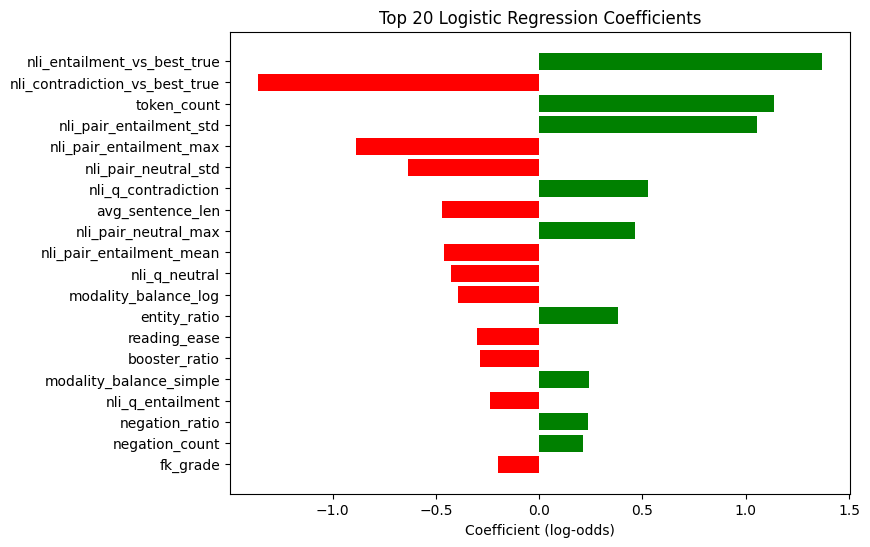

,feature,coefficient
1,nli_entailment_vs_best_true,1.367037
3,nli_contradiction_vs_best_true,-1.360439
7,token_count,1.134318
33,nli_pair_entailment_std,1.055556
31,nli_pair_entailment_max,-0.884478
37,nli_pair_neutral_std,-0.635605
27,nli_q_contradiction,0.525733
8,avg_sentence_len,-0.468515
35,nli_pair_neutral_max,0.462047
32,nli_pair_entailment_mean,-0.461555


In [ ]:

# Refit once on full data to extract coefficients cleanly
pipe.fit(X, y)
coef = pipe.named_steps["logreg"].coef_[0]
feature_names = feature_cols

# Pair feature names with coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})

# Sort by absolute value
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).head(20)

# Plot
plt.figure(figsize=(8,6))
colors = ["green" if c > 0 else "red" for c in coef_df["coefficient"]]
plt.barh(coef_df["feature"], coef_df["coefficient"], color=colors)
plt.gca().invert_yaxis()
plt.title("Top 20 Logistic Regression Coefficients")
plt.xlabel("Coefficient (log-odds)")
plt.show()

coef_df.drop(columns="abs_coef")


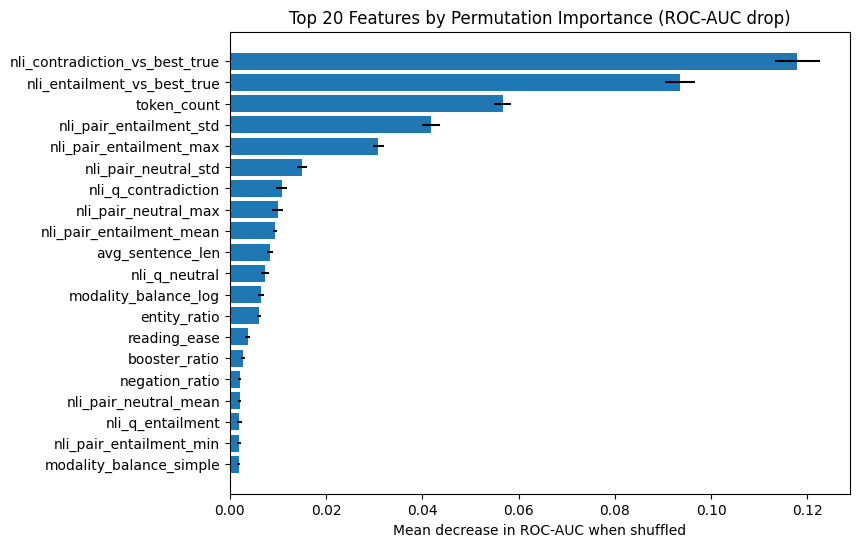

,feature,importance_mean,importance_std
3,nli_contradiction_vs_best_true,0.117937,0.004760
1,nli_entailment_vs_best_true,0.093532,0.003075
7,token_count,0.056715,0.001756
33,nli_pair_entailment_std,0.041741,0.001860
31,nli_pair_entailment_max,0.030824,0.001173
37,nli_pair_neutral_std,0.015024,0.001007
27,nli_q_contradiction,0.010766,0.001107
35,nli_pair_neutral_max,0.009907,0.001066
32,nli_pair_entailment_mean,0.009426,0.000389
8,avg_sentence_len,0.008345,0.000631


In [ ]:
# Refit once on full dataset for permutation importance
pipe.fit(X, y)

result = permutation_importance(pipe, X, y, scoring="roc_auc", n_repeats=10, random_state=42, n_jobs=-1)
result = cast(Bunch, result)  

perm_df = pd.DataFrame({
    "feature": feature_cols,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False).head(20)

# Plot top 20
plt.figure(figsize=(8,6))
plt.barh(perm_df["feature"], perm_df["importance_mean"], xerr=perm_df["importance_std"])
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Permutation Importance (ROC-AUC drop)")
plt.xlabel("Mean decrease in ROC-AUC when shuffled")
plt.show()

perm_df


## Random Forest Comparison

We evaluate a Random Forest classifier as an alternative to logistic regression.  
The model is trained and validated using 5-fold group cross-validation (grouped by question ID to prevent data leakage).  
Performance metrics include ROC-AUC, PR-AUC, and F1 score, enabling direct comparison with the logistic regression baseline.  
We also visualize the Random Forest’s feature importances to identify which features contribute most to predictions.  


In [ ]:
# Define Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

cv = GroupKFold(n_splits=5)

rf_scores = cross_validate(
    rf, X, y,
    cv=cv,
    groups=df["qid"].to_numpy(),
    scoring=["roc_auc", "average_precision", "f1"],
    return_train_score=False,
    n_jobs=-1
)

print("Random Forest Results:")
print("ROC-AUC:", rf_scores["test_roc_auc"].mean())
print("PR-AUC:", rf_scores["test_average_precision"].mean())
print("F1:", rf_scores["test_f1"].mean())


Random Forest Results:
ROC-AUC: 0.9545962586581866
PR-AUC: 0.956057427595199
F1: 0.878260448608712


## Random Forest Feature Importance

The Random Forest model highlights NLI features as especially important, even more so than in the logistic regression results.  
This reflects the model’s ability to capture non-linear relationships and feature interactions, which further amplifies the predictive value of NLI features in distinguishing true from false answers.  


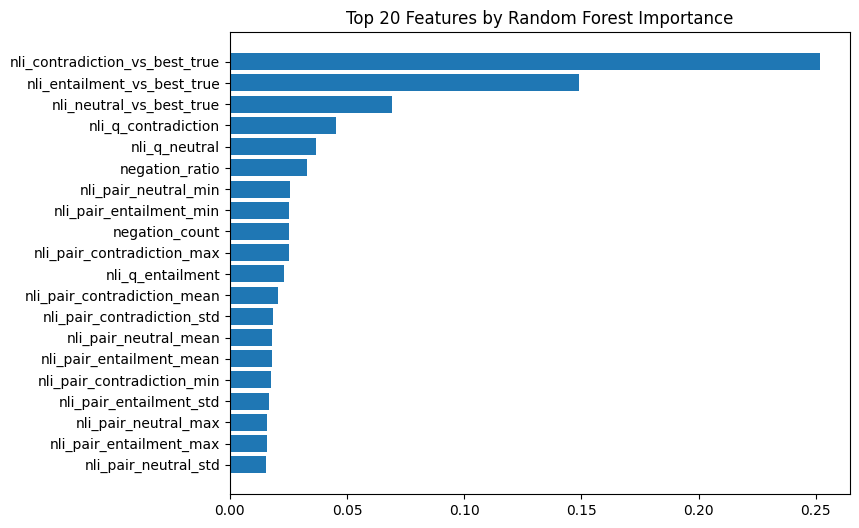

,feature,importance
3,nli_contradiction_vs_best_true,0.251878
1,nli_entailment_vs_best_true,0.148748
2,nli_neutral_vs_best_true,0.069060
27,nli_q_contradiction,0.045214
28,nli_q_neutral,0.036708
16,negation_ratio,0.033065
34,nli_pair_neutral_min,0.025788
30,nli_pair_entailment_min,0.025300
15,negation_count,0.025047
39,nli_pair_contradiction_max,0.025030


In [ ]:
importances = rf.fit(X, y).feature_importances_
rf_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(rf_imp_df["feature"], rf_imp_df["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Random Forest Importance")
plt.show()

rf_imp_df


## Summary & Next Steps

In this notebook, we evaluated how engineered features relate to answer correctness using logistic regression and Random Forest models.  

**Key Takeaways for GHI Weighting:**  
- **NLI features** consistently emerged as the strongest predictors of true vs. false answers. This suggests they should receive **higher weight** in the GHI metric.  
- **Readability and lexical features** showed moderate but consistent separation, indicating they should remain part of the schema but with **lower relative weight**.  
- **Entity and semantic similarity features** provided useful signal, though their influence varied by model, suggesting they may serve best as **supporting weights** rather than core drivers.  
- Random Forest highlighted the importance of **non-linear interactions** between features, reinforcing the value of a balanced weighting system rather than relying on any single feature category.  

**Next Steps:**  
- Translate these findings into a preliminary GHI weighting schema, assigning proportional influence to NLI, readability/lexical, and entity-based features.  
- Test the proposed schema against baseline metrics (BLEU, ROUGE) to ensure it improves alignment with ground-truth labels.  
- Refine weights iteratively based on validation results across multiple datasets.  

This analysis provides the foundation for moving from raw feature engineering to a principled weighting strategy within the GHI metric.  
